In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave, mimsave
import glob
import os
from tqdm import tqdm

In [2]:
images = glob.glob('data/train/*.jpg') + glob.glob('data/val/*.jpg')
print(len(images))

500


In [3]:
X_all = []
Y_all = []
WIDTH = 256
HEIGHT = 256
for image in images:
    img = imread(image)
    img = (img / 255. - 0.5) * 2
    # B2A
    # 分离图像, 右边是x,左边是y
    X_all.append(img[:, WIDTH:, :])
    Y_all.append(img[:, :WIDTH, :])
X_all = np.array(X_all)
Y_all = np.array(Y_all)
print(X_all.shape, Y_all.shape)

(500, 256, 256, 3) (500, 256, 256, 3)


(256, 512, 3)


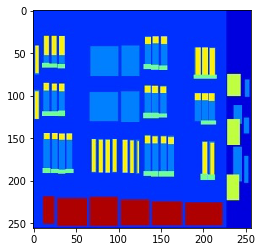

In [13]:
# 看看image
a = imread(images[0])
a = np.array(a)
print(a.shape)
# x
a1 = a[:,WIDTH:, :]
# y
a2 = a[:, :WIDTH, :]
plt.imshow(a1)
plt.show()

In [14]:
batch_size = 1
LAMBDA = 100

OUTPUT_DIR = 'samples'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

X = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='Y')
k_initializer = tf.random_normal_initializer(0, 0.02)
g_initializer = tf.random_normal_initializer(1, 0.02)

def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)

def d_conv(inputs, filters, strides):
    padded = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
    return tf.layers.conv2d(padded, kernel_size=4, filters=filters, strides=strides, padding='valid', kernel_initializer=k_initializer)

def g_conv(inputs, filters):
    return tf.layers.conv2d(inputs, kernel_size=4, filters=filters, strides=2, padding='same', kernel_initializer=k_initializer)
    
def g_deconv(inputs, filters):
    return tf.layers.conv2d_transpose(inputs, kernel_size=4, filters=filters, strides=2, padding='same', kernel_initializer=k_initializer)

def batch_norm(inputs):
    return tf.layers.batch_normalization(inputs, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=g_initializer)

def sigmoid_cross_entropy_with_logits(x, y):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)

In [15]:
def discriminator(x, y, reuse=None):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.concat([x, y], axis=3)    
        h0 = lrelu(d_conv(x, 64, 2)) # 128 128 64
        
        h0 = d_conv(h0, 128, 2)
        h0 = lrelu(batch_norm(h0)) # 64 64 128
        
        h0 = d_conv(h0, 256, 2)
        h0 = lrelu(batch_norm(h0)) # 32 32 256
        
        h0 = d_conv(h0, 512, 1)
        h0 = lrelu(batch_norm(h0)) # 31 31 512
        
        h0 = d_conv(h0, 1, 1) # 30 30 1
        h0 = tf.nn.sigmoid(h0)
        
        return h0

In [16]:
def generator(x):
    with tf.variable_scope('generator', reuse=None):
        layers = []
        h0 = g_conv(x, 64)
        layers.append(h0)
        
        for filters in [128, 256, 512, 512, 512, 512, 512]:
            h0 = lrelu(layers[-1])
            h0 = g_conv(h0, filters)
            h0 = batch_norm(h0)
            layers.append(h0)
        
        encode_layers_num = len(layers) # 8
        
        for i, filters in enumerate([512, 512, 512, 512, 256, 128, 64]):
            skip_layer = encode_layers_num - i - 1
            if i == 0:
                inputs = layers[-1]
            else:
                inputs = tf.concat([layers[-1], layers[skip_layer]], axis=3)
            h0 = tf.nn.relu(inputs)
            h0 = g_deconv(h0, filters)
            h0 = batch_norm(h0)
            if i < 3:
                h0 = tf.nn.dropout(h0, keep_prob=0.5)
            layers.append(h0)
        
        inputs = tf.concat([layers[-1], layers[0]], axis=3)
        h0 = tf.nn.relu(inputs)
        h0 = g_deconv(h0, 3)
        h0 = tf.nn.tanh(h0, name='g')
        return h0

In [17]:
g = generator(X)
d_real = discriminator(X, Y)
d_fake = discriminator(X, g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

loss_d_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_real, tf.ones_like(d_real)))
loss_d_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake, tf.zeros_like(d_fake)))
loss_d = loss_d_real + loss_d_fake

loss_g_gan = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake, tf.ones_like(d_fake)))
loss_g_l1 = tf.reduce_mean(tf.abs(Y - g))
loss_g = loss_g_gan + loss_g_l1 * LAMBDA

In [18]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss = {'d': [], 'g': []}

for i in tqdm(range(100000)):
    k = i % X_all.shape[0]
    X_batch, Y_batch = X_all[k:k + batch_size, :, :, :], Y_all[k:k + batch_size, :, :, :]
    
    _, d_ls = sess.run([optimizer_d, loss_d], feed_dict={X: X_batch, Y: Y_batch})
    _, g_ls = sess.run([optimizer_g, loss_g], feed_dict={X: X_batch, Y: Y_batch})
    
    loss['d'].append(d_ls)
    loss['g'].append(g_ls)
    
    if i % 1000 == 0:
        print(i, d_ls, g_ls)
        gen_imgs = sess.run(g, feed_dict={X: X_batch})
        result = np.zeros([HEIGHT, WIDTH * 3, 3])
        result[:, :WIDTH, :] = (X_batch[0] + 1) / 2
        result[:, WIDTH: 2 * WIDTH, :] = (Y_batch[0] + 1) / 2
        result[:, 2 * WIDTH:, :] = (gen_imgs[0] + 1) / 2
        plt.axis('off')
        plt.imshow(result)
        imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), result)
        plt.show()

plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig('Loss.png')
plt.show()

In [ ]:
saver = tf.train.Saver()
saver.save(sess, './pix2pix_diy', global_step=100000)